In [47]:
from analytics_utils.partial_autocorrelation import partial_autocorrelation
from analytics_utils.linear_regression import linear_regression
from analytics_utils.autocorrelation import autocorrelation
from analytics_utils.describe_data import describe_data
from analytics_utils.interpolate import interpolate
from analytics_utils.decomposers import seasonal
from analytics_utils.correlate import correlate
from statsmodels.tsa.stattools import adfuller
from analytics_utils.roll import roll
from analytics_utils.ewm import ewm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

---

## Global variables

In [48]:
ARGS = {
    "mucuri_h": "/home/ferraz/dev/my/prediction-wind-speed-mp/confidential/headers.csv",
    "mucuri_t": "/home/ferraz/dev/my/prediction-wind-speed-mp/confidential/train150.txt",
    "mucuri_p": "/home/ferraz/dev/my/prediction-wind-speed-mp/confidential/prev150.txt",
    "drups_df": "temp/bear_log.csv",
}

---

## Functions

In [49]:
#Perform Dickey-Fuller test:
def dftest(df):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

---

## Mucuri Analysis

### Load and show datas

In [70]:
# Load dataset
headers = pd.read_csv(ARGS['mucuri_h'], header=None).iloc[0]
_t = pd.read_csv(ARGS['mucuri_t'], delimiter='\t', header=None, names=headers)
_p = pd.read_csv(ARGS['mucuri_p'], delimiter='\t', header=None, names=headers)
df_m = pd.concat([_t, _p], ignore_index=True)
df_m

,Dia,Mês,Ano,Hora,Velocidade,Direção,Temperatura,Umidade,Pressão
0,30,11,2015,14,13.012139,75.105481,27.516129,72.930636,1020.422601
1,30,11,2015,15,12.726087,68.334332,27.238095,75.212121,1020.394348
2,30,11,2015,16,12.081111,64.457865,27.105263,75.741379,1020.508333
3,30,11,2015,17,11.647222,53.842100,26.305556,75.302632,1020.611000
4,30,11,2015,18,11.064444,53.945279,25.464286,76.592593,1020.866500
5,30,11,2015,19,10.324444,51.320714,24.764706,83.344444,1021.286500
6,30,11,2015,20,9.862778,47.354507,24.310811,88.044643,1021.627500
7,30,11,2015,21,9.598889,41.816108,24.304348,91.329670,1021.892333
8,30,11,2015,22,9.488889,39.561270,24.500000,92.415385,1021.856167
9,30,11,2015,23,7.502222,37.881537,24.419355,93.629630,1021.834667


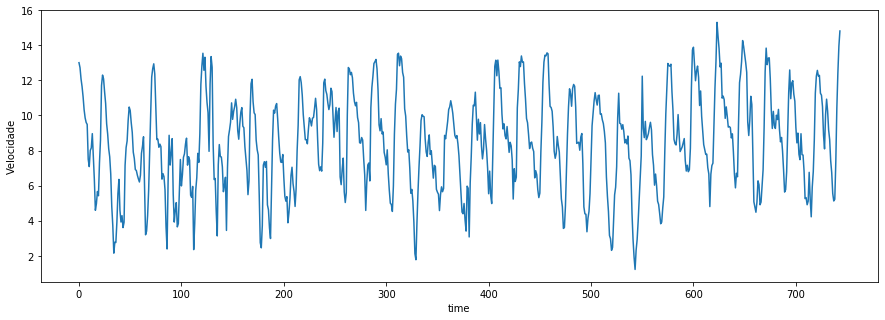

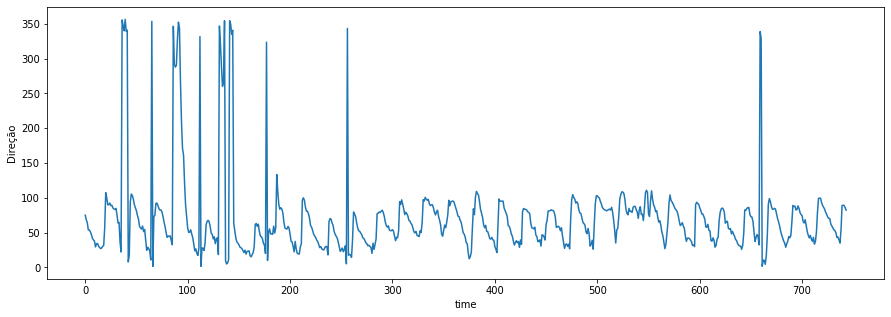

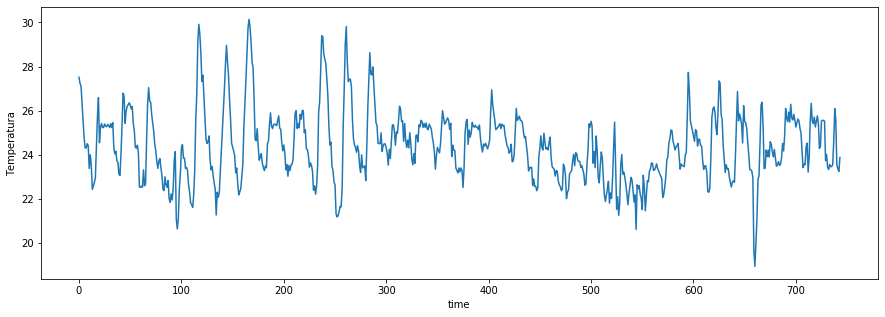

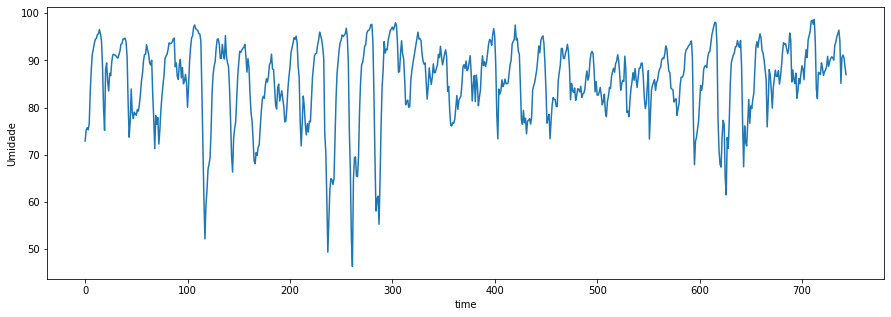

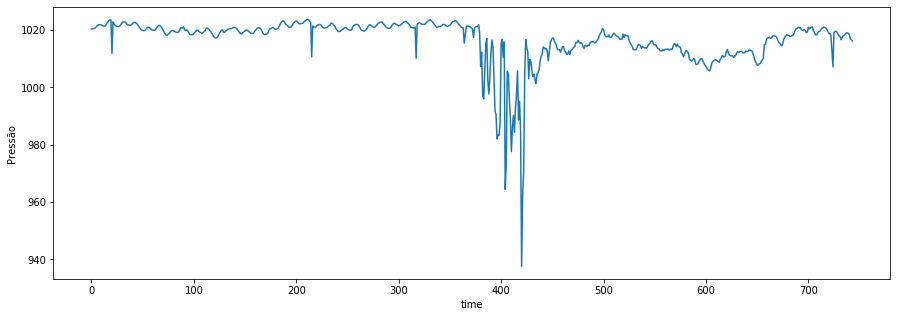

In [67]:
# Show evolution chart
for column in df_m.columns[4:]:
    _, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    ax = sns.lineplot(data=df_m.loc[:, column], ax=ax1)
    ax.set(xlabel='time', ylabel=column)

---

### Preprocessing (nan values)

In [72]:
describe_data(df_m)

,max,min,média,mediana,1-quartil,3-quartil,variância,desvio padrão,desvio absoluto,amplitude,rms,curtose,assimetria,contagem,NaNs
cabeçalho,,,,,,,,,,,,,,,
Dia,31.000000,1.000000,15.986559,16.000000,8.000000,24.000000,79.717181,8.928448,7.728928,30.000000,18.307925,-1.210866,-0.007436,744,0
Mês,12.000000,11.000000,11.986559,12.000000,12.000000,12.000000,0.013278,0.115230,0.026520,1.000000,11.987112,69.890489,-8.467740,744,0
Ano,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,2015.000000,0.000000,0.000000,744,0
Hora,23.000000,0.000000,11.500000,11.500000,5.750000,17.250000,47.981157,6.926843,6.000000,23.000000,13.422618,-1.204198,0.000000,744,0
Velocidade,15.313889,1.211905,8.440594,8.489167,6.498889,10.404306,7.586714,2.754399,2.245532,14.101984,8.878071,-0.583534,-0.064374,744,0
Direção,356.553715,1.448179,70.913340,59.891964,39.725962,83.353583,3464.189743,58.857368,32.925486,355.105536,92.131620,12.907184,3.402864,744,0
Temperatura,30.140625,18.936170,24.391007,24.310811,23.354245,25.373400,2.538095,1.593140,1.231791,11.204455,NaN,1.074509,0.538121,743,1
Umidade,98.710843,46.355556,85.680048,87.350906,81.606481,91.520952,68.308641,8.264904,6.349837,52.355288,86.077218,2.108927,-1.237156,744,0
Pressão,1023.726500,937.534333,1016.543352,1019.163250,1014.022208,1021.024417,63.461228,7.966256,5.070307,86.192167,1016.574524,23.052438,-3.844125,744,0


---

### Interpolation

In [69]:
# Linear interpolation
inter_l = interpolate(df_m, method='linear')
inter_l

,Dia,Mês,Ano,Hora,Velocidade,Direção,Temperatura,Umidade,Pressão
0,30,11,2015,14,13.012139,75.105481,27.516129,72.930636,1020.422601
1,30,11,2015,15,12.726087,68.334332,27.238095,75.212121,1020.394348
2,30,11,2015,16,12.081111,64.457865,27.105263,75.741379,1020.508333
3,30,11,2015,17,11.647222,53.842100,26.305556,75.302632,1020.611000
4,30,11,2015,18,11.064444,53.945279,25.464286,76.592593,1020.866500
5,30,11,2015,19,10.324444,51.320714,24.764706,83.344444,1021.286500
6,30,11,2015,20,9.862778,47.354507,24.310811,88.044643,1021.627500
7,30,11,2015,21,9.598889,41.816108,24.304348,91.329670,1021.892333
8,30,11,2015,22,9.488889,39.561270,24.500000,92.415385,1021.856167
9,30,11,2015,23,7.502222,37.881537,24.419355,93.629630,1021.834667


In [71]:
# Cubic interpolation
inter_c = interpolate(df_m, method="cubic")
inter_c

,Dia,Mês,Ano,Hora,Velocidade,Direção,Temperatura,Umidade,Pressão
0,30,11,2015,14,13.012139,75.105481,27.516129,72.930636,1020.422601
1,30,11,2015,15,12.726087,68.334332,27.238095,75.212121,1020.394348
2,30,11,2015,16,12.081111,64.457865,27.105263,75.741379,1020.508333
3,30,11,2015,17,11.647222,53.842100,26.305556,75.302632,1020.611000
4,30,11,2015,18,11.064444,53.945279,25.464286,76.592593,1020.866500
5,30,11,2015,19,10.324444,51.320714,24.764706,83.344444,1021.286500
6,30,11,2015,20,9.862778,47.354507,24.310811,88.044643,1021.627500
7,30,11,2015,21,9.598889,41.816108,24.304348,91.329670,1021.892333
8,30,11,2015,22,9.488889,39.561270,24.500000,92.415385,1021.856167
9,30,11,2015,23,7.502222,37.881537,24.419355,93.629630,1021.834667


In [81]:
# Choose linear or cubic interpolation for next steps
df_inter = inter_c

---

### Describe datas

In [82]:
# Datas description
describe_m = describe_data(df_inter)
describe_m

,max,min,média,mediana,1-quartil,3-quartil,variância,desvio padrão,desvio absoluto,amplitude,rms,curtose,assimetria,contagem,NaNs
cabeçalho,,,,,,,,,,,,,,,
Dia,31.000000,1.000000,15.986559,16.000000,8.000000,24.000000,79.717181,8.928448,7.728928,30.000000,18.307925,-1.210866,-0.007436,744,0
Mês,12.000000,11.000000,11.986559,12.000000,12.000000,12.000000,0.013278,0.115230,0.026520,1.000000,11.987112,69.890489,-8.467740,744,0
Ano,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,2015.000000,0.000000,0.000000,744,0
Hora,23.000000,0.000000,11.500000,11.500000,5.750000,17.250000,47.981157,6.926843,6.000000,23.000000,13.422618,-1.204198,0.000000,744,0
Velocidade,15.313889,1.211905,8.440594,8.489167,6.498889,10.404306,7.586714,2.754399,2.245532,14.101984,8.878071,-0.583534,-0.064374,744,0
Direção,356.553715,1.448179,70.913340,59.891964,39.725962,83.353583,3464.189743,58.857368,32.925486,355.105536,92.131620,12.907184,3.402864,744,0
Temperatura,30.140625,18.936170,24.390728,24.309817,23.356368,25.370910,2.534736,1.592086,1.230401,11.204455,24.442564,1.080181,0.538987,744,0
Umidade,98.710843,46.355556,85.680048,87.350906,81.606481,91.520952,68.308641,8.264904,6.349837,52.355288,86.077218,2.108927,-1.237156,744,0
Pressão,1023.726500,937.534333,1016.543352,1019.163250,1014.022208,1021.024417,63.461228,7.966256,5.070307,86.192167,1016.574524,23.052438,-3.844125,744,0


---

### Show datas chart with your descriptions

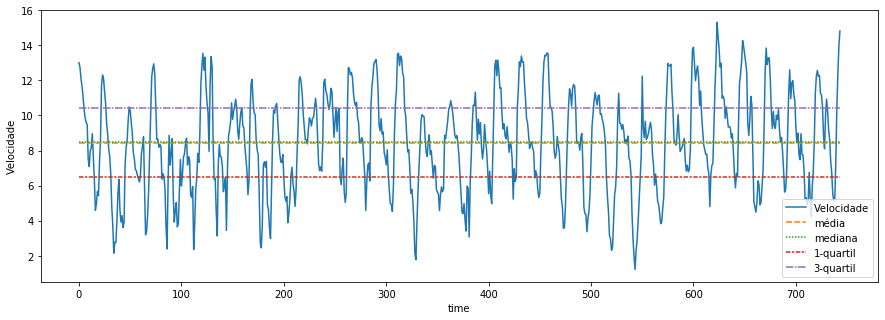

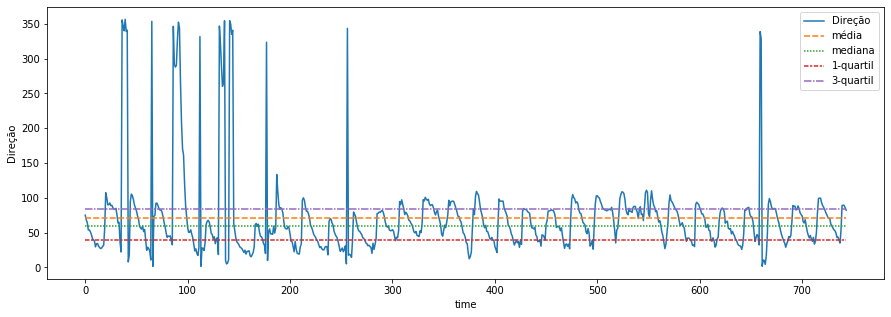

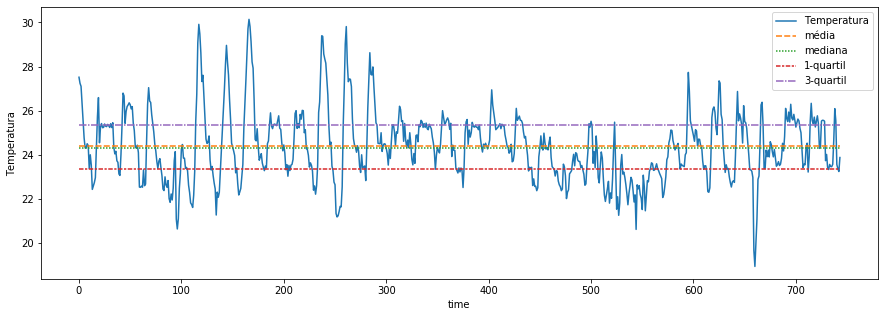

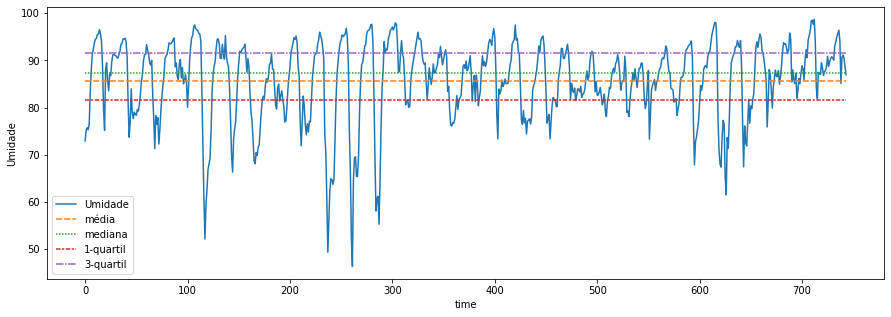

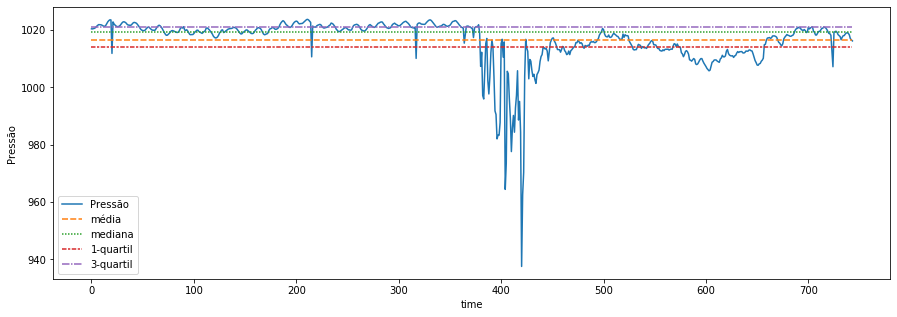

In [133]:
# Show descriptions chart
dm = ["média", "mediana", "1-quartil", "3-quartil"]

for column in df_inter.columns[4:]:
    _, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    
    df_aux = df_inter.loc[:,[column]].copy()
    for measure in dm:
        df_aux[f"{measure}"] = describe_m.loc[column, measure]
        
    ax = sns.lineplot(data=df_aux, ax=ax1)
    ax.set(xlabel='time', ylabel=column)

---

### Boxplots

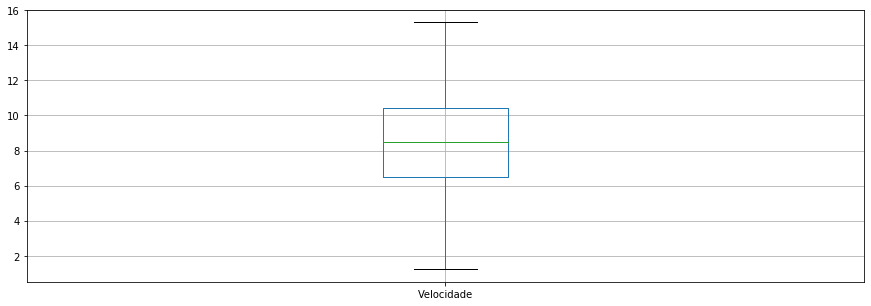

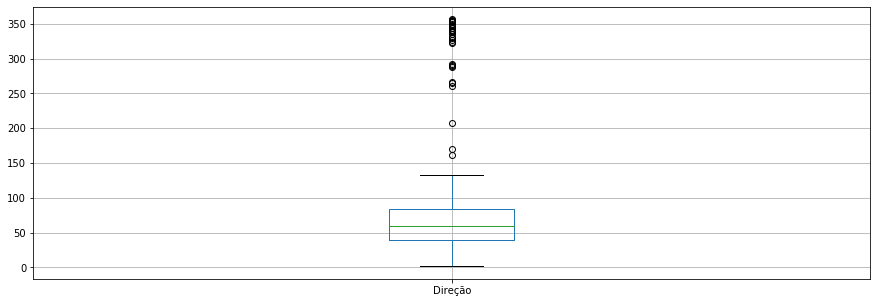

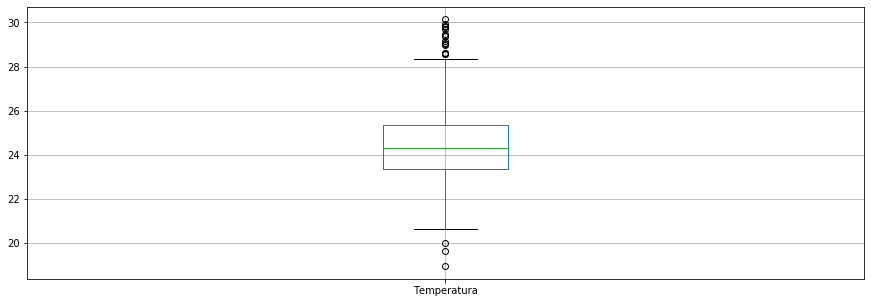

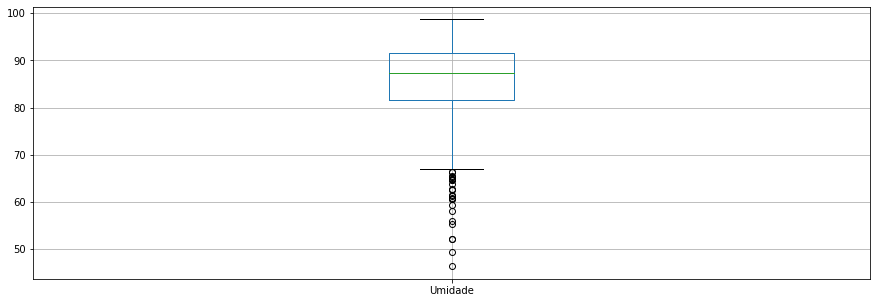

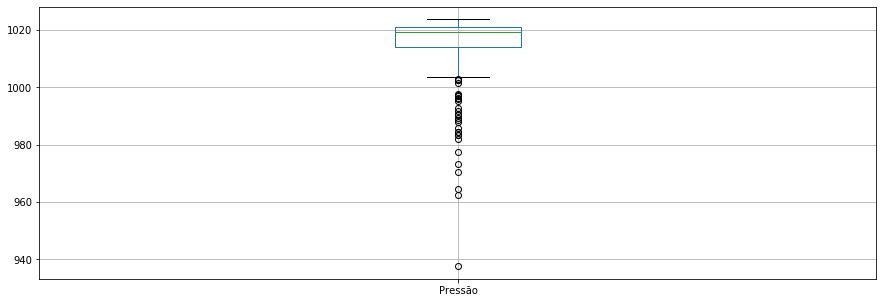

In [138]:
for c in inter_c.columns[4:]:
    _, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    inter_c.boxplot(column=c, figsize=(15, 5), ax=ax1)

## correlate

correlate(
    data_frame: pd.DataFrame, method: str = "pearson", min_periods: int = 1
) -> pd.DataFrame

- methos types: {‘pearson’, ‘kendall’, ‘spearman’}

In [ ]:
# Show correlation matrix datas
corr = correlate(df)
display(corr)

In [ ]:
# Show correlation matrix
# sns.heatmap(corr, vmin=-1, vmax=1, cmap='coolwarm')
plt.figure(figsize=(12, 9))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', square=True)

---

## interpolate

- Please note that only method='linear' is supported for DataFrame/Series with a MultiIndex.
- methods types: {‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’, ‘krogh’, ‘polynomial’, ‘spline’ ‘piecewise_polynomial’, ‘pchip’}

In [ ]:
# Show interpolate linear
inter_linear = interpolate(df.iloc[:,0], method="linear")
inter_linear = inter_linear.rename(inter_linear.name+"_linear")
display(inter_linear)

In [ ]:
# Show interpolate cubic
inter_cubic = interpolate(df.iloc[:,0], method="cubic")
inter_cubic = inter_cubic.rename(inter_cubic.name+"_cubic")
display(inter_cubic)

In [ ]:
# Show [0] column of time series with cubic and linear interpolate
wide_df = df.iloc[:,0].copy()
wide_df = pd.concat([wide_df, inter_linear, inter_cubic], axis=1)
display(wide_df)

In [ ]:
# Show plot [0] column of time series with cubic and linear interpolate
zero_df = df.iloc[:,0].copy()
linear_df = pd.concat([zero_df, inter_linear], axis=1)
cubic_df = pd.concat([zero_df, inter_cubic], axis=1)

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.lineplot(data=linear_df, ax=ax1)
sns.lineplot(data=cubic_df, ax=ax2)

---

## roll (rolling window)

def roll(
    data_frame: pd.DataFrame,
    window: int,
    roll_type: str = "mean",
    headers: [str] = None,
) -> pd.DataFrame

- roll_type: {‘mean’, ‘var’, 'std'}

In [ ]:
# Show moving average, std and var in the column zero
roll_df = cubic_df.iloc[:,1].copy()
m_roll = roll(roll_df, 24, roll_type="mean")
m_roll = m_roll.rename(m_roll.name+"_mean")
std_roll = roll(roll_df, 24, roll_type="std")
std_roll = std_roll.rename(std_roll.name+"_std")
var_roll = roll(roll_df, 24, roll_type="var")
var_roll = var_roll.rename(var_roll.name+"_var")
wide_rdf = pd.concat([roll_df, m_roll, std_roll, var_roll], axis=1)
display(wide_rdf)

In [ ]:
# Show graphic moving average, std and var in the column zero
fig = plt.figure(figsize=(16, 12))
ax = sns.lineplot(data=wide_rdf)

In [ ]:
# Show Dickey-Fuller test
dftest(roll_df.dropna())

## roll - method of stationary a time serie

In [ ]:
# Show moving average, std and var in the column zero (stationary)
roll_df_stat = (roll_df - m_roll).copy()
m_roll_stat = roll(roll_df_stat, 24, roll_type="mean")
m_roll_stat = m_roll_stat.rename("stat_mean")
std_roll_stat = roll(roll_df_stat, 24, roll_type="std")
std_roll_stat = std_roll_stat.rename("stat_std")
var_roll_stat = roll(roll_df_stat, 24, roll_type="var")
var_roll_stat = var_roll_stat.rename("stat_var")
wide_rdf_stat = pd.concat([roll_df_stat, m_roll_stat, std_roll_stat, var_roll_stat], axis=1)
display(wide_rdf_stat)

In [ ]:
# Show graphic moving average, std and var in the column zero (stationary)
fig = plt.figure(figsize=(16, 12))
ax = sns.lineplot(data=wide_rdf_stat)

In [ ]:
# Show Dickey-Fuller test (stationary)
dftest(roll_df_stat.dropna())

---

## ewm (exponential weighted moving)

def ewm(
        data_frame: pd.DataFrame,
        com: float = None,
        span: float = None,
        halflife: float = None,
        alpha: float = None,
        ignore_na: bool = False,
        ewm_type: str = "mean",
        headers: [str] = None,
    ) -> pd.DataFrame

- com: α=1/(1+com), for com≥0
- span: α=2/(span+1), for span≥1
- halflife: α=1−exp(log(0.5)/halflife), for halflife>0
- alpha: 0<α≤1
- ewm_types: {‘mean’, ‘var’, 'std'}

In [ ]:
# Show ewm average, std and var in the column zero
ewm_df = cubic_df.iloc[:,1].copy()
m_ewm = ewm(ewm_df, halflife=24, ewm_type="mean")
m_ewm = m_ewm.rename(m_ewm.name+"_mean")
std_ewm = ewm(ewm_df, halflife=24, ewm_type="std")
std_ewm = std_ewm.rename(std_ewm.name+"_std")
var_ewm = ewm(ewm_df, halflife=24, ewm_type="var")
var_ewm = var_ewm.rename(var_ewm.name+"_var")
wide_edf = pd.concat([ewm_df, m_ewm, std_ewm, var_ewm], axis=1)
display(wide_edf)

In [ ]:
# Show graphic ewm average, std and var in the column zero
fig = plt.figure(figsize=(16, 12))
ax = sns.lineplot(data=wide_edf)

In [ ]:
# Show Dickey-Fuller test (real value - mean value)
dftest(ewm_df.dropna())

## ewm - method of stationary a time serie

In [ ]:
# Show ewm average, std and var in the column zero (stationary)
ewm_df_stat = (ewm_df - m_ewm).copy() # or ewm_df - ewm_df.shift() for diferentiation
m_ewm_stat = ewm(ewm_df_stat, halflife=24, ewm_type="mean")
m_ewm_stat = m_ewm_stat.rename("stat_mean")
std_ewm_stat = ewm(ewm_df_stat, halflife=24, ewm_type="std")
std_ewm_stat = std_ewm_stat.rename("stat_std")
var_ewm_stat = ewm(ewm_df_stat, halflife=24, ewm_type="var")
var_ewm_stat = var_ewm_stat.rename("stat_var")
wide_edf_stat = pd.concat([ewm_df_stat, m_ewm_stat, std_ewm_stat, var_ewm_stat], axis=1)
display(wide_edf_stat)

In [ ]:
# Show graphic ewm average, std and var in the column zero (stationary)
fig = plt.figure(figsize=(16, 12))
ax = sns.lineplot(data=wide_edf_stat)

In [ ]:
# Show Dickey-Fuller test (stationary)
dftest(ewm_df_stat.dropna())

---

## seasonal

def seasonal(
    data_frame: pd.DataFrame,
    model: str = "additive",
    filt: [] = None,
    freq: int = None,
    two_sided: bool = True,
    extrapolate_trend: int = 0,
    lang: str = "pt",
    headers: [str] = None,
) -> pd.DataFrame

- model: {“additive”, “multiplicative”}

## decompose additive

In [ ]:
# Show seasonal decompose (additive)
decompose_add = seasonal(inter_cubic.dropna(), model='additive', freq=24)

observed_add = decompose_add.iloc[0,0].rename("observed")
seasonal_add = decompose_add.iloc[0,1].rename("seasonal")
trend_add = decompose_add.iloc[0,2].rename("trend")
resid_add = decompose_add.iloc[0,3].rename("resid")

wide_df_add = pd.concat([observed_add, seasonal_add, trend_add, resid_add], axis=1)
wide_df_add

In [ ]:
# Show graphic seasonal decompose (additive)
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

sns.lineplot(data=observed_add, ax=ax1)
sns.lineplot(data=seasonal_add, ax=ax2)
sns.lineplot(data=trend_add, ax=ax3)
sns.lineplot(data=resid_add, ax=ax4)

## decompose multiplicative

In [ ]:
# Show seasonal decompose (multiplicative)
decompose_mult = seasonal(inter_cubic.dropna(), model='multiplicative', freq=24)

observed_mult = decompose_mult.iloc[0,0].rename('observed')
seasonal_mult = decompose_mult.iloc[0,1].rename('seasonal')
trend_mult = decompose_mult.iloc[0,2].rename('tend')
resid_mult = decompose_mult.iloc[0,3].rename('resid')

wide_df_mult = pd.concat([observed_mult, seasonal_mult, trend_mult, resid_mult], axis=1)
wide_df_mult

In [ ]:
# Show graphic seasonal decompose (additive)
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

sns.lineplot(data=observed_mult, ax=ax1)
sns.lineplot(data=seasonal_mult, ax=ax2)
sns.lineplot(data=trend_mult, ax=ax3)
sns.lineplot(data=resid_mult, ax=ax4)

---

## autocorrelation

def autocorrelation(
    data_frame: pd.DataFrame,
    unbiased: bool = False,
    nlags: int = 40,
    fft: bool = None,
    alpha: float = None,
    missing: str = "none",
    headers: [str] = None,
) -> pd.DataFrame

- missing: {‘none’, ‘raise’, ‘conservative’, ‘drop’}

In [ ]:
auto = autocorrelation(observed_mult, fft=False)
auto

In [ ]:
sns.lineplot(data=auto)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(observed_mult, lags=40)

---

## partial_autocorrelation

def partial_autocorrelation(
    data_frame: pd.DataFrame,
    nlags: int = 40,
    method: str = "ywunbiased",
    alpha: float = None,
    headers: [str] = None,
) -> pd.DataFrame

- method: {‘yw’ or ‘ywunbiased’, ‘ywm’ or ‘ywmle’, ‘ols’, ‘ols-inefficient’, ‘ols-unbiased’, ‘ld’ or ‘ldunbiased’, ‘ldb’ or ‘ldbiased’}

In [ ]:
partial_auto = partial_autocorrelation(observed_mult)
partial_auto

In [ ]:
sns.lineplot(data=partial_auto)

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(observed_mult, lags=40)

---

## linear_regression

def linear_regression(
    data_frame: pd.DataFrame,
    fit_intercept: bool = True,
    normalize: bool = False,
    copy_X: bool = True,
    n_jobs: int = None,
    offset: int = 1,
    regressors: [str] = None,
    predictors: [str] = None,
) -> pd.DataFrame

In [ ]:
regress = linear_regression(df, regressors=["T_room"], predictors=["T_room"])
regress

In [ ]:
sns.lineplot(data=regress)

In [ ]:
sns.lineplot(data=df.loc[:,"T_room"])

---

## Drups Analysis

In [ ]:
# df = pd.read_csv('', parse_dates={'datetime': ['date', 'time']}, index_col='datetime').iloc[:1000,2:]
# df = pd.read_csv('temp/repsol.csv', parse_dates=['data'], index_col='data')[:1000]